We will test the accuracy of the algorithm with artificially generated data 


We will have a total of 5 states and a total of 9 possible clusters for the hosts to be part of.


Based on these clusters and their centroid transition matrix, a data series will be generated for each host

First set the parameters of the states

In [1]:
import numpy as np

lambdas = np.vstack([[0,0], [15,20], [37,12], [7,48], [55,75]])
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# random plot of the data
# number of points to take from each distribution centroid
size = 1000

for i, lambda_i in enumerate(lambdas):
    s1 = np.random.poisson(lambda_i[0], size)
    s2 = np.random.poisson(lambda_i[1], size)

    if i == 0:
        data = np.column_stack((s1, s2, np.array([i]*size, dtype=object)))
    else:
        data = np.append(data, np.column_stack((s1, s2, np.array([i]*size, dtype=object))), axis=0)

np.random.shuffle(data)

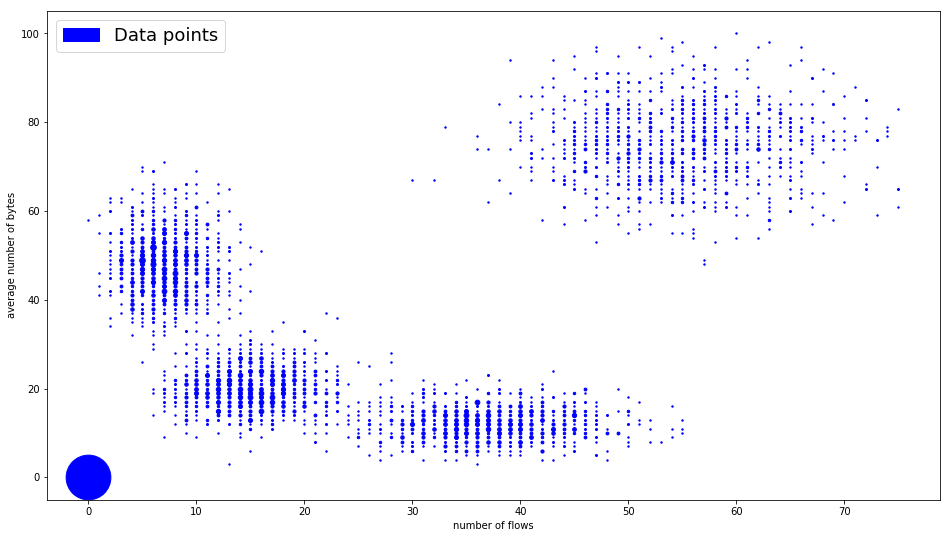

In [2]:
from plots import plot_points
%matplotlib inline

plot_points(data[:, :2])

As we can see the clusters are clearly seperated 

More precisely based only on the mass function of the distributions, the accuracy is as following

In [3]:
import scipy.stats.distributions


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

correct_classified = 0
for point in data:
    classification = np.argmax([poisson(point[:2], lambda_i) for lambda_i in lambdas])
    if classification == point[2]:
        correct_classified += 1
        
print('Accuracy of origin cluster based on mass function', correct_classified / len(data) * 100, '%')

Accuracy of origin cluster based on mass function 99.6 %


Now we will create the clusters

We will create a number of clusters containing different number of hosts each

In [4]:
import random as ran

L = 9
num_hosts_per_L = [10, 20, 30, 40, 50, 60, 70, 80, 150]

def random_vector(size=5):
    vec = [ran.random() for i in range(size)]
    return np.array(vec) / sum(vec)

def random_transition_matrix(size=5):
    return np.vstack([random_vector(size=size) for i in range(size)])

In [5]:
transition_matrices = []
for i in range(L):
    transition_matrices.append(random_transition_matrix(size=len(lambdas)))

Create the points for each individual host

In [6]:
data_points = []
number_of_epochs = 500

def add_random_points(data_points, host_name, distribution, lambdas, epoch):
    axis0 = np.random.poisson(lambdas[distribution][0], 1)[0]
    axis1 = np.random.poisson(lambdas[distribution][1], 1)[0]
    data_points.append([axis0, axis1, epoch, host_name])

def random_next_state(transition_matrices, i, previous_distribution):
    r = ran.random()
    return np.where(transition_matrices[i][previous_distribution].cumsum() >= r)[0][0]
    
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        # random starting distribution
        previous_distribution = ran.randint(0, len(lambdas) - 1)
        add_random_points(data_points, host_name, previous_distribution, lambdas, 1)
        
        for k in range(2, number_of_epochs + 1):
            next_distribution = random_next_state(transition_matrices, i, previous_distribution)
            
            add_random_points(data_points, host_name, next_distribution, lambdas, k)
            
            previous_distribution = next_distribution
            

data_points = np.array(data_points,  dtype=object)

Run the EM Algorithm and the clustering

An important note is that the EM mixtures might not converge from the beginning to the desired points so on the starting epochs some of the results might not be the desired ones. This should not be a problem though.

In [7]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus
import numpy as np
import pandas as pd

In [11]:
mixtures = len(lambdas)

kplusplus = KPlusPlus(mixtures, data_points[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5


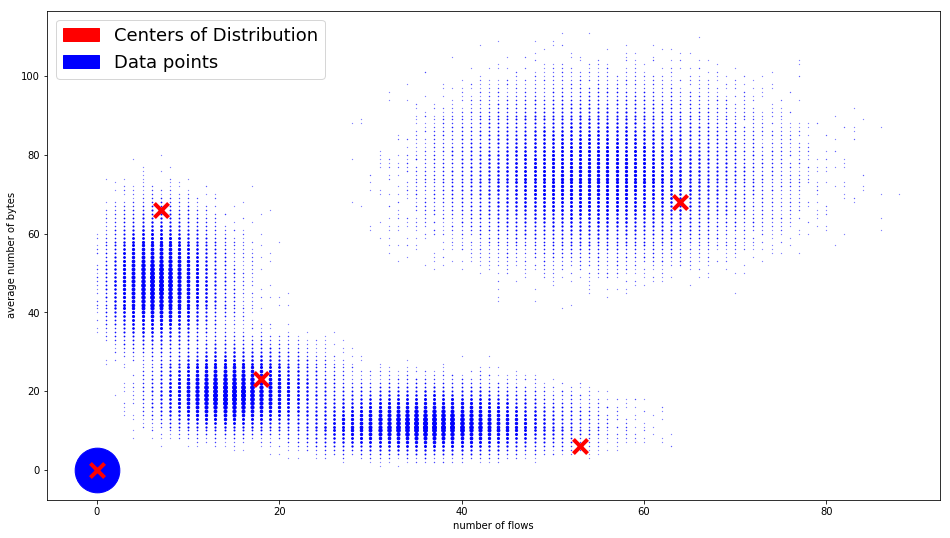

In [12]:
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, sum(num_hosts_per_L), verbose=0, update_power=0.5)

plot_points(data_points[:, :2], onlineEM)

In [13]:
onlineEM.fit(data_points[:,[0,1,3]])

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:205: RuntimeWarning: invalid value encountered in true_divide
  previous)
D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


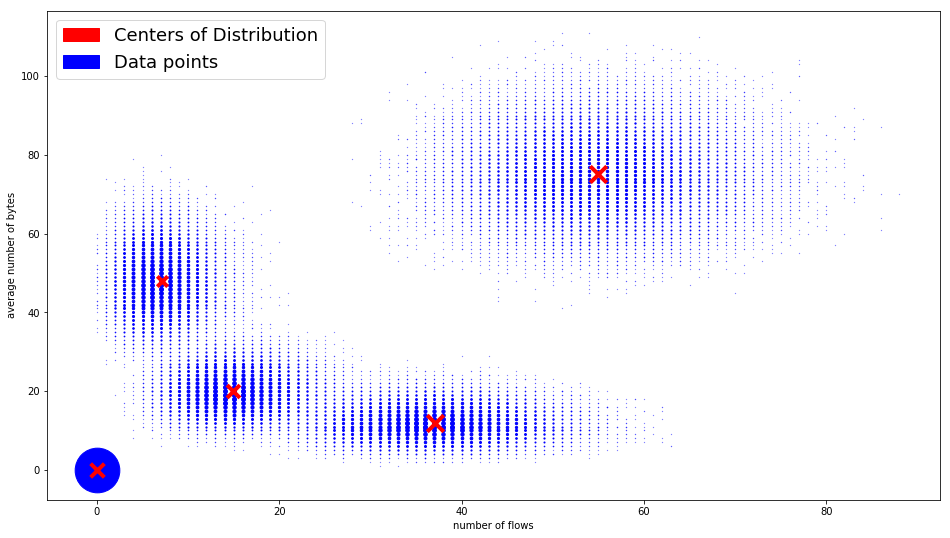

In [14]:
plot_points(data_points[:, :2], onlineEM)

In [15]:
print(onlineEM.gammas)
print(onlineEM.lambdas)

[ 0.26837174  0.18746152  0.16461142  0.10687039  0.27268492]
[[54.939969828117569 75.105609980375135]
 [0.0 0.0]
 [14.884883076358943 20.021246991090919]
 [7.1232047034782937 48.050642062782799]
 [37.100157936629756 11.994555130941626]]


Now we can cluster the transition matrices 

In [16]:
from numpy.linalg import norm
import random as ran
import numpy as np
from math import log
from scipy.linalg import eig 

def find_stationary(transition_matrix):
    S, U = eig(transition_matrix.T)
    stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
    stationary = stationary / np.sum(stationary)
    return np.abs(stationary)


def kl_distance(P, Q):
    total_distance = 0
    for i in range(len(P)):
        if Q[i] == 0 or P[i] == 0:
            continue
        total_distance += P[i] * log(P[i]/Q[i])
            
    return total_distance

"""def kl_distance2(P, Q):
    total_distance = 0
    for i in range(len(P)):
        if P[i] == 0:
            continue
        total_distance += P[i] * log(P[i]/((Q[i] + P[i])/2))
    return total_distance"""

def kl_distance2(P, Q):
    total_distance = 0
    for i in range(len(P)):
        if P[i] == 0:
            continue
        total_distance += P[i] * log(P[i] / Q[i])
        
    return total_distance

def solveStationary(A):
    """ x = xA where x is the answer
    x - xA = 0
    x( I - A ) = 0 and sum(x) = 1
    """
    n = A.shape[0]
    a = np.eye( n ) - A
    a = np.vstack( (a.T, np.ones( n )) )
    b = np.matrix( [0] * n + [ 1 ] ).T
    return np.squeeze(np.asarray(np.linalg.lstsq( a, b )[0]))

def distance(A1, A2):
    stationary = solveStationary(A1)
    return sum([stationary[i] * (2*kl_distance2(A1[i], A2[i])) for i in range(len(stationary))])
    #return sum([(2*kl_distance2(A1[i], A2[i])) for i in range(len(stationary))])

def hmm_distance(A1, A2):
    return (distance(A1, A2) + distance(A2, A1)) / 2

class kMeans:
    def __init__(self, em, n_clusters=3, initial_centers=None, n_iters=20, n_runs=10):
        self.em = em
        self.initial_centers = initial_centers
        self.n_clusters = n_clusters
        self.n_iters = n_iters
        self.n_runs = n_runs
        
    def _transition_matrices_for_cluster(self, k, assignments):
        members = [key for key, value in assignments.items() if value == k]

        matrices = []
        for host in members:
            matrices.append(self.em.hosts[host]['transition_matrix'])

        return np.array(matrices)

    def _compute_centroids(self, assignments):
        C = np.zeros(shape=(self.n_clusters, self.em.m, self.em.m), dtype='d')
        
        for k in range(self.n_clusters):

            if not (np.array(list(assignments.values())) == k).any():
                continue
                
            matrices = self._transition_matrices_for_cluster(k, assignments)
            C[k] = np.mean(matrices, axis=0)
        return C

    def _cost(self, C, assignments):
        cost = 0
        for k in range(self.n_clusters):
            matrices = self._transition_matrices_for_cluster(k, assignments)
            for transition_matrix in matrices:
                cost += hmm_distance(transition_matrix, C[k])
        return cost
        
    def run(self):
        min_cost = float('+inf')
        best_C = None
        best_assignment = None
        
        for _ in range(self.n_runs):
            print('Starting run')
            # random initialize the assignment of each host to a cluster
            assignments = dict(zip(onlineEM.hosts, np.random.randint(0, self.n_clusters, len(onlineEM.hosts))))
            
            C = self._compute_centroids(assignments)
            
            C, assignments = self._base_kmeans(C)
            clust_cost = self._cost(C, assignments)

            if clust_cost < min_cost:
                min_cost = clust_cost
                best_C = C.copy()
                best_assignment = assignments.copy()
            
        self.assignments = best_assignment
        self.centers = best_C   
        return best_C, best_assignment


    def _base_kmeans(self, C):
        n = len(self.em.hosts)

        C_final = C

        #KMeans algorithm
        cent_dists = None
        assignments = None
        prev_assignments = None
        best_shift = None

        iters = self.n_iters
        converged = False

        while iters != 0 and not converged:
            #assign elements to new clusters    
            assignments = {}
            for host in self.em.hosts:
                distances = np.array([hmm_distance(self.em.hosts[host]['transition_matrix'], C_final[i]) 
                                      for i in range(self.n_clusters)])
                assignments[host] = np.argmin(distances)

            #check if converged, if not compute new centroids
            if prev_assignments is not None and prev_assignments == assignments:
                converged = True
                print('converged')
            else: 
                C_final = self._compute_centroids(assignments)
                print('The cost is', self._cost(C_final, assignments))

            prev_assignments = assignments
            iters -= 1

        return C_final, assignments
                
    def classify(self, data_point):
        return min(range(self.n_clusters), key=lambda p: hmm_distance(data_point, self.centers[p]))

Insert bias to avoid zeros

In [17]:
import numpy as np

m = onlineEM.m

initialize = np.eye(m)

for i in range(m):
    for j in range(m):
        if i != j:
            initialize[i][j] = 0.5
            
    initialize[i] /= (1 + 0.5 * (m - 1))

In [18]:
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, points in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

In [21]:
kmeans = kMeans(onlineEM, n_clusters=L, initial_centers=None, n_iters=15, n_runs=5)
C, assign = kmeans.run()

Starting run
The cost is 101.884430725


c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


The cost is 42.5948773698
The cost is 41.5088913818
The cost is 41.5026012448
converged
Starting run
The cost is 84.3123225319
The cost is 21.9497256315
The cost is 20.6445948584
converged
Starting run
The cost is 92.7313209722
The cost is 54.0874236679
The cost is 39.6709468552
The cost is 38.4428742152
converged
Starting run
The cost is 77.6884481649
The cost is 47.1220584943
The cost is 43.3970710973
The cost is 40.2023446475
The cost is 40.1960143799
The cost is 40.1895815188
The cost is 40.1848295057
The cost is 40.1720177629
The cost is 40.1547922293
The cost is 40.1527700511
The cost is 40.1504269606
The cost is 40.1484257926
converged
Starting run
The cost is 56.1304079525
The cost is 37.5866337457
The cost is 36.7737323793
converged


In [22]:
centroids = np.zeros(shape=(L, L), dtype=np.int64)
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        
        participation = assign[host_name]
        centroids[i][participation] += 1
    
centroids

array([[ 10,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  20,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  30,   0,   0],
       [  0,   0,   0,   0,  40,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  50],
       [  0,   0,  60,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  70,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  80,   0],
       [  0, 150,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)